# Track Record
Dieses Notebook dient dazu, die Performance eines Forecast am Markt für die letzten 8 Jahre zu ermitteln. Dazu gelten folgende Regeln:
- Startbudget: 10.000€
- Ein Kauf/Verkauf pro Monat
- Vorhersagen werden am Anfang des Jahres unter Einbezug aller vorherigen Daten als Kontext gemacht.

In [38]:
# Imports
import pandas as pd
from track_record_helpers import get_df_from_Sample_Forecast

In [25]:
# Import forecasts and get single time series from it.
forecast_list = pd.read_pickle('../modelling/backtests/8_windows/v5/8year_test_forecasts.pkl')
forecast_df = pd.DataFrame()

for forecast in forecast_list:
    df = get_df_from_Sample_Forecast(forecast)
    forecast_df = pd.concat((forecast_df, df), axis=0)

forecast_df['forecast_mean'] = forecast_df.mean(axis=1)
forecast_df.drop(axis=1, columns=list(range(100)), inplace=True)
forecast_df.head(450)

,forecast_mean
2015-06-08,2128.038574
2015-06-15,2132.137939
2015-06-22,2135.332520
2015-06-29,2143.436768
2015-07-06,2146.945557
...,...
2023-04-24,3565.853516
2023-05-01,3528.875244
2023-05-08,3520.271484
2023-05-15,3508.763184


In [26]:
# Import the actual time series
indices_df = pd.read_csv('./financial_ts/indices.csv', index_col=0)
snp_series = indices_df['S&P']
snp_series

1971-02-08        NaN
1971-02-15        NaN
1971-02-22        NaN
1971-03-01        NaN
1971-03-08        NaN
               ...   
2023-04-24    4132.07
2023-05-01    4166.79
2023-05-08    4136.98
2023-05-15    4126.65
2023-05-22    4190.78
Name: S&P, Length: 2729, dtype: float64

In [52]:
# Set input parameters for the track record calculation
budget = 10000
risk_factor = 1
trading_interval = 4

# Calculate track record
track_record = pd.DataFrame(columns=['Date', 'Action', 'Forecast', 'Actual', 'Return (%)', 'Budget', 'LongOnly'])
track_record['Date'] = forecast_df.index
track_record['Forecast'] = forecast_df['forecast_mean'].values
track_record['Actual'] = snp_series.values[-forecast_df.shape[0]:]

# Set the LongOnly strategy column
norm_factor = track_record.at[0, 'Actual'] / budget
track_record['LongOnly'] = track_record['Actual'] / norm_factor

# Calculate monthly returns and track record
for i in range(0, len(track_record), trading_interval):

    # Get the forecasted movemnt within the next 4 weeks
    forecasted_change = (track_record['Forecast'].iloc[i + trading_interval- 1] - track_record['Forecast'].iloc[i]) / track_record['Forecast'].iloc[i]
    actual_change = (track_record['Actual'].iloc[i + trading_interval - 1] - track_record['Actual'].iloc[i]) / track_record['Actual'].iloc[i]
    actual_change = 0 if pd.isna(actual_change) else actual_change # Do not trade when index data is missing

    # print(f"Index {i}: \nForecasted Change: {forecasted_change} \nActual Change: {actual_change}")

    if forecasted_change > 0:
        action = 'Buy'
        budget *= (1 + risk_factor * actual_change)
    else:
        action = 'Sell'
        budget *= (1 - risk_factor * actual_change)
    
    action = 'Nothing' if actual_change == 0 else action

    # Update the track record DataFrame
    track_record.at[i, 'Action'] = action
    track_record.at[i, 'Return (%)'] = actual_change
    track_record.at[i, 'Budget'] = budget

# Print the track record
print(track_record.head(420))

          Date Action     Forecast   Actual Return (%)        Budget   
0   2015-06-08    Buy  2128.038574  2092.34   0.003006  10030.062036  \
1   2015-06-15    NaN  2132.137939  2091.34        NaN           NaN   
2   2015-06-22    NaN  2135.332520  2112.50        NaN           NaN   
3   2015-06-29    NaN  2143.436768  2098.63        NaN           NaN   
4   2015-07-06    Buy  2146.945557  2073.95   0.002044  10050.567575   
..         ...    ...          ...      ...        ...           ...   
411 2023-04-24    NaN  3565.853516  4132.07        NaN           NaN   
412 2023-05-01   Sell  3528.875244  4166.79   0.005757     5671.7317   
413 2023-05-08    NaN  3520.271484  4136.98        NaN           NaN   
414 2023-05-15    NaN  3508.763184  4126.65        NaN           NaN   
415 2023-05-22    NaN  3484.627197  4190.78        NaN           NaN   

         LongOnly  
0    10000.000000  
1     9995.220662  
2    10096.351453  
3    10030.062036  
4     9912.107975  
..            .

## Track record analysis
Further analysis on top of the track record

In [46]:
import matplotlib.pyplot as plt

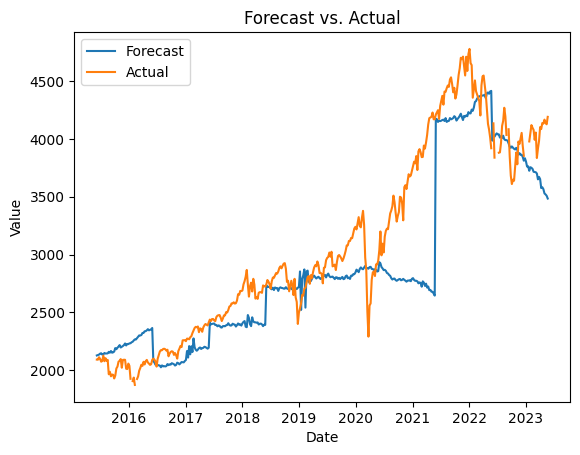

In [59]:
plt.plot(track_record['Date'], track_record['Forecast'], label='Forecast')
plt.plot(track_record['Date'], track_record['Actual'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs. Actual')
plt.legend()
plt.show()

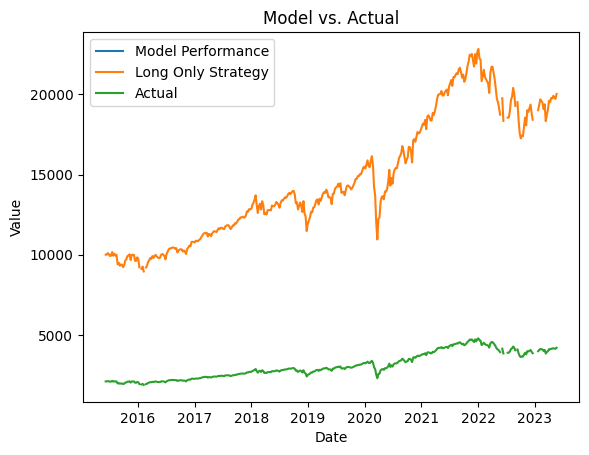

In [62]:
# Plot the models track record vs. a long only strategy
plt.plot(track_record['Date'], track_record['Budget'].interpolate(), label='Model Performance')
plt.plot(track_record['Date'], track_record['LongOnly'], label='Long Only Strategy')
plt.plot(track_record['Date'], track_record['Actual'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Model vs. Actual')
plt.legend()
plt.show()
# TODO: Check why the Model Performance is not plotted.

In [48]:
print(f"Value counts for the actions: \n{track_record['Action'].value_counts()}")

Value counts for the actions: 
Action
Buy        52
Sell       48
Nothing     4
Name: count, dtype: int64
